# Training an intents classification model

Define constants

In [1]:
from os import getcwd, path
import sys
import matplotlib.pyplot as plt
import numpy as np

BASE_PATH = path.dirname(getcwd())
sys.path.append(BASE_PATH)

DATA_UTILS = path.join(BASE_PATH, 'common/data_utils.py')
TRAIN_PATH = path.join(BASE_PATH, 'kc_data.json')
CLASSES_FILE = path.join(BASE_PATH, 'classes.json')

from text_classification.fast_text.train import trainIters

In [2]:
exec(open(DATA_UTILS).read())

Use functions from the utils to extract and preprocess the training data
Refer to `kc_data.json` for the sample data format
`get_data_pairs` is then used to parse data into a tuple of `([list_of_sentences], [list_of_labels])`

In [3]:
X_data, y_data = get_data_pairs(data_from_json(TRAIN_PATH))

classes = list(set(y_data))
num_classes = len(classes)

X_train = X_data
y_train = np.array([
    classes.index(item)
    for item in y_data
], dtype='float32')

Plot the training data

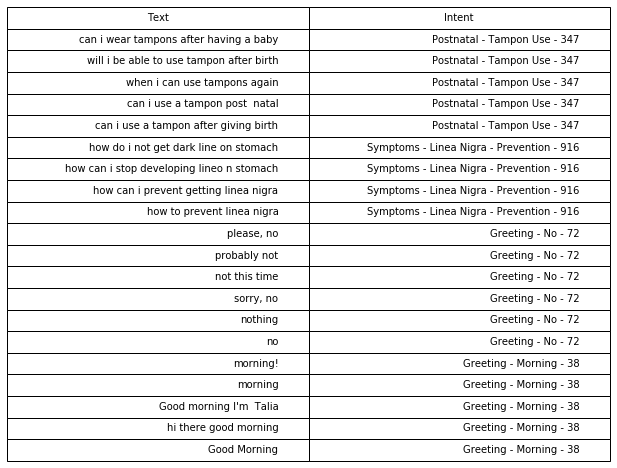

In [4]:
cell_text = [
    [item, y_data[idx] + ' - ' + str(int(y_train[idx]))] 
    for (idx, item) in enumerate(X_train)
]
plt.table(cellText=cell_text[:20],
          colLabels=['Text', 'Intent'],
          loc='center') \
   .scale(1.8,1.8)
plt.axis('off')
plt.show()

In [5]:
print('Number of samples: %s, classes: %s' % (len(X_train), num_classes))

Number of samples: 10256, classes: 1427


Save the classes descriptions as json

In [6]:
import json

with open(CLASSES_FILE, 'w') as classes_file:
    json.dump(classes, classes_file)

In [7]:
import torch
torch.__version__

'0.4.0a0+5463a4a'

Start training the classification model and save

In [8]:
training_data = [(item, y_train[idx]) for idx, item in enumerate(X_train)]

losses, model = trainIters(training_data, 
                           classes, 
                           n_iters=100, 
                           log_every=5, 
                           verbose=1, 
                           learning_rate=3e-3,
                           weight_decay=0.3,
                           batch_size=64)
model.eval()

Training started
4m 33s (- 86m 37s) (5 5%) 0.0001 - accuracy: 0.0055
7m 20s (- 66m 4s) (10 10%) 0.0000 - accuracy: 0.0073
10m 14s (- 58m 4s) (15 15%) 0.0000 - accuracy: 0.0082
13m 22s (- 53m 30s) (20 20%) 0.0000 - accuracy: 0.0369
16m 34s (- 49m 42s) (25 25%) 0.0000 - accuracy: 0.1596
19m 39s (- 45m 52s) (30 30%) 0.0000 - accuracy: 0.3198
22m 41s (- 42m 8s) (35 35%) 0.0000 - accuracy: 0.4465
25m 45s (- 38m 38s) (40 40%) 0.0000 - accuracy: 0.5342
28m 26s (- 34m 45s) (45 45%) 0.0000 - accuracy: 0.5963
30m 56s (- 30m 56s) (50 50%) 0.0000 - accuracy: 0.6465
33m 24s (- 27m 20s) (55 55%) 0.0000 - accuracy: 0.6849
35m 51s (- 23m 54s) (60 60%) 0.0000 - accuracy: 0.7169
38m 17s (- 20m 36s) (65 65%) 0.0000 - accuracy: 0.7425
40m 45s (- 17m 27s) (70 70%) 0.0000 - accuracy: 0.7625
43m 47s (- 14m 35s) (75 75%) 0.0000 - accuracy: 0.7796
46m 55s (- 11m 43s) (80 80%) 0.0000 - accuracy: 0.7943
50m 5s (- 8m 50s) (85 85%) 0.0000 - accuracy: 0.8056
53m 0s (- 5m 53s) (90 90%) 0.0000 - accuracy: 0.8149
56m 

FastText(
  (ngrams_embs): Embedding(2097152, 300, padding_idx=0, sparse=True)
  (i2h): Linear(in_features=300, out_features=100, bias=True)
  (h2o): Linear(in_features=100, out_features=1427, bias=True)
)

In [9]:
print(model.temperature.item())

1.5


Plot the losses graph (this helps choosing number of epochs and learning rate)

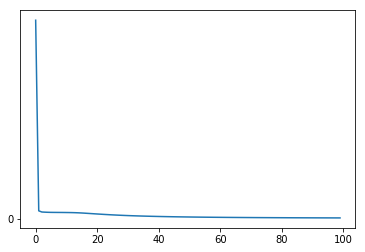

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
fig, ax = plt.subplots()
loc = ticker.MultipleLocator(base=5)
ax.yaxis.set_major_locator(loc)
plt.plot(losses)

Test the trained model

In [14]:
from text_classification.fast_text.predict import predict
import torch.nn.functional as F

TEST_SENTENCE = 'Good morning!'

with torch.no_grad():
    scores = model([TEST_SENTENCE], True)
    print(scores.size())
    topk_scores, topk_idx = torch.topk(scores, 5)
    print(topk_scores[0])
    print(F.sigmoid(topk_scores[0]))
    print(topk_idx[0])
    print(topk_scores[0,0])
    print(classes[topk_idx[0,0].item()])

torch.Size([1, 1427])

 193.8374
  76.0659
  66.6292
  65.2489
  64.3647
[torch.FloatTensor of size (5,)]


 1
 1
 1
 1
 1
[torch.FloatTensor of size (5,)]


   38
 1051
  578
  940
   93
[torch.LongTensor of size (5,)]


 193.8374
[torch.FloatTensor of size ()]

Greeting - Morning
